# Group memebrs:
## Taban Nikdel 300337079
## Cheng-Yi Chen 300335751


**Project Goal:**
* The goal of this project is detecting dog and cat from pigtures by using YOLO V5 algorithm.

**Subtask**
* Dog and cat claasification.
* Locate the target object (plot the bounding box).

**YOLO-V5 Installation**
* YOLO is not available for installin by paper install like other algorithms and libraries.
* Go to AlexeyAB Github and clone the yolov5 repositary.

In [1]:
# Download the YOLO-V5 repository.
!git clone https://github.com/ultralytics/yolov5.git


Cloning into 'yolov5'...
remote: Enumerating objects: 14992, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14992 (delta 0), reused 1 (delta 0), pack-reused 14989
Receiving objects: 100% (14992/14992), 14.01 MiB | 8.90 MiB/s, done.
Resolving deltas: 100% (10294/10294), done.


In [2]:
# Install all requirements.
%cd /kaggle/working/yolov5
!pip install -r requirements.txt

/kaggle/working/yolov5


In [3]:
# Install beautyful soup library.
%pip install bs4

  Preparing metadata (setup.py) ... - done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=a7a4ad9889df39f95ff677fbf59422b35158d495dcd50ead5331c9b6ec4fe250
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


**Training Preparation & Dataset Processing**
In this step, we are going to:
* Convert the XML labels files to txt files.
* Prepare the training set and validation set.
* Prepare the experiment tracking functionality of Weights & Biases platform.

In [4]:
# Import required libraries to process the label data.
from glob import glob
from bs4 import BeautifulSoup
import os

In [5]:
# Create a label list of label xmal files. 
labels_dir = list(sorted(glob("/kaggle/input/dog-and-cat-detection/annotations/*.xml")))
#labels_dir

In [6]:
# Create dataset->export->labels foler and a list of txt lables.
text_labels_dir = '/dataset/export/labels'
os.makedirs(text_labels_dir, exist_ok = True)

In [7]:
# Change labels from xml to txt.
for labels in labels_dir : 
    with open(labels, 'r') as f :
        data = f.read()
        soup = BeautifulSoup(data, 'xml')

        img_size = soup.find('size')
        img_width = int(img_size.find('width').text)
        img_height = int(img_size.find('height').text)

        objects = soup.find_all('object')
        obj_list = []
        class_lambda = lambda x : 0 if x == 'cat' else 1
        for obj in objects :
            label = class_lambda(obj.find('name').text)
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)

            x = ((xmin + xmax) / 2) / img_width
            y = ((ymin + ymax) / 2) / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            obj_list.append([label, x, y, width, height])
        
        txt_label_dir = text_labels_dir + '/' + labels[47:-4] + '.txt'
        with open(txt_label_dir, 'w') as f :
            for obj in obj_list :
                f.write(str(obj[0]) + ' ' +\
                        str(obj[1]) + ' ' +\
                        str(obj[2]) + ' ' +\
                        str(obj[3]) + ' ' +\
                        str(obj[4]))

In [8]:
# Import required library to process the images.
from distutils.dir_util import copy_tree

In [9]:
# Create a images directory under the export directory.
imgs_dir = '/dataset/export/images'
os.makedirs(imgs_dir, exist_ok = True)

In [10]:
# Copy the iamges to the new directory.
copy_tree("/kaggle/input/dog-and-cat-detection/images",\
          imgs_dir)

['/dataset/export/images/Cats_Test3283.png',
 '/dataset/export/images/Cats_Test727.png',
 '/dataset/export/images/Cats_Test1584.png',
 '/dataset/export/images/Cats_Test1196.png',
 '/dataset/export/images/Cats_Test2587.png',
 '/dataset/export/images/Cats_Test2783.png',
 '/dataset/export/images/Cats_Test209.png',
 '/dataset/export/images/Cats_Test2574.png',
 '/dataset/export/images/Cats_Test2748.png',
 '/dataset/export/images/Cats_Test886.png',
 '/dataset/export/images/Cats_Test3389.png',
 '/dataset/export/images/Cats_Test3297.png',
 '/dataset/export/images/Cats_Test794.png',
 '/dataset/export/images/Cats_Test666.png',
 '/dataset/export/images/Cats_Test3414.png',
 '/dataset/export/images/Cats_Test1037.png',
 '/dataset/export/images/Cats_Test3193.png',
 '/dataset/export/images/Cats_Test63.png',
 '/dataset/export/images/Cats_Test3469.png',
 '/dataset/export/images/Cats_Test1688.png',
 '/dataset/export/images/Cats_Test30.png',
 '/dataset/export/images/Cats_Test1388.png',
 '/dataset/export/i

In [11]:
# Import the spliter.
from sklearn.model_selection import train_test_split

In [12]:
# Splite the image dataset for traning and validation.
img_list = glob(imgs_dir + '/*.png')
train_img, valid_img = train_test_split(img_list, test_size = 0.1, random_state = 0)

In [13]:
# Save training and validation image list.
with open('/dataset/train.txt', 'w') as f:
    f.write('\n'.join(train_img) + '\n')
with open('/dataset/val.txt', 'w') as f:
    f.write('\n'.join(valid_img) + '\n')

In [14]:
# Import yaml library to prepare configuration.
import yaml

In [15]:
# Define the yaml file for training.
with open('/dataset/data.yaml', 'w') as f:
    data = {
        'train' : '/dataset/train.txt',
        'val' : '/dataset/val.txt',
        'nc' : 2,
        'names' : ['cat', 'dog']
    }
    yaml.dump(data, f)

In [16]:
# Import experiment tracking required libraries.
import wandb
from kaggle_secrets import UserSecretsClient

In [17]:
!wandb login 21465de25859eaffda1e68ba138a5ad5dc4370cb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Training Cat And Dog Detector**

In [18]:
!python train.py \
--img 416 \
--batch 16 \
--epochs 10 \
--data /dataset/data.yaml \
--cfg ./models/yolov5s.yaml \
--weights yolov5s.pt \
--name cat_and_dog_yolov5s_results

wandb: Currently logged in as: stebingeo17 (taker22). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=cat_and_dog_yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-70-g589edc7 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_mome

**Validate the detector.**

In [19]:
# Check the model path.

%cd /kaggle/working/yolov5/runs/train/cat_and_dog_yolov5s_results/weights
%ls

/kaggle/working/yolov5/runs/train/cat_and_dog_yolov5s_results/weights
best.pt  last.pt


In [20]:
# Import image display package and choose a image from validation set ramdomly.
from IPython.display import Image
val_img = valid_img[40]
print(val_img)

/dataset/export/images/Cats_Test701.png


In [21]:
%cd /kaggle/working/yolov5
!python detect.py \
--weights /kaggle/working/yolov5/runs/train/cat_and_dog_yolov5s_results/weights/best.pt \
--img 416 \
--conf 0.5 \
--source "{val_img}"

/kaggle/working/yolov5
detect: weights=['/kaggle/working/yolov5/runs/train/cat_and_dog_yolov5s_results/weights/best.pt'], source=/dataset/export/images/Cats_Test701.png, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-70-g589edc7 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /dataset/export/images/Cats_Test701.png: 416x288 1 cat, 9.6ms
Speed: 0.3ms pre-process, 9.6ms inference, 2.3ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp


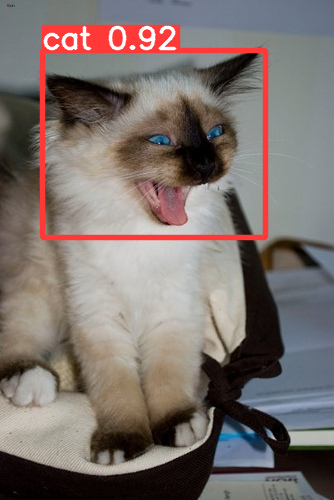

In [22]:
Image(os.path.join('/kaggle/working/yolov5/runs/detect/exp', os.path.basename(val_img)))